### Import libraries

In [77]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import numpy as np
import json
import math
import datetime
import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

source= 'lfm' # 'spotify' or 'lfm'

CSV generated in notebook 02b (spotify) or 00b (lfm)

In [78]:
ranking_df= pd.read_csv(os.path.join('data', 'clean_ranking_2017_2022_v2.csv'), index_col=0, parse_dates=['Date', 'release_date'])

if source== 'lfm':
    ranking_df= pd.read_csv(os.path.join('data', 'LMF-2b', 'clean_ranking_2005_2020_lfm.csv'), index_col=0, parse_dates=['Date', 'release_date'])

/home/fterroso/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [79]:
ranking_df['week_of_study']= ranking_df['day_of_study'].apply(lambda x : int(x/7))

In [80]:
ranking_df.head()

,song_id,Date,Streams,Region,release_date,day_of_study,Position,week_of_study
18,991,2016-12-22,11,Belarus,2016-12-22,4325,1.0,617
19,991,2017-01-23,22,Belarus,2016-12-22,4357,4.0,622
20,991,2017-01-24,27,Belarus,2016-12-22,4358,13.0,622
21,991,2016-12-29,11,Russia,2016-12-22,4332,1.0,618
86,4774,2012-08-22,11,Brazil,2012-06-13,2742,1.0,391


In [81]:
release_countries = ranking_df[ranking_df['Date']==ranking_df['release_date']][['song_id','Region']]

In [82]:
release_countries.head()

,song_id,Region
18,991,Belarus
91,4774,Finland
134,7411,Ukraine
222,18627,USA
239,20946,Finland


In [83]:
release_countries.shape

(175526, 2)

In [84]:
ranking_df['song_id'].nunique()

171493

### Plot with sheer number of songs per country

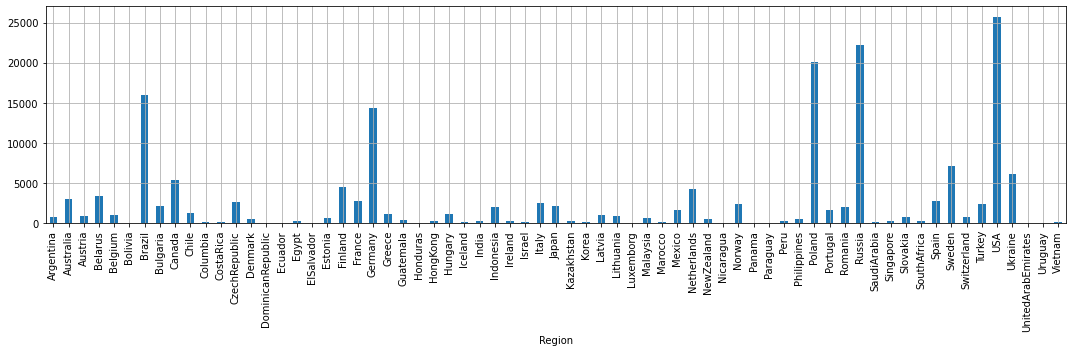

In [85]:
songs_per_country=release_countries.groupby('Region').size().sort_index().to_frame()
songs_per_country=songs_per_country.rename(columns={0:'n_songs'})
songs_per_country.plot(kind='bar', grid=True, figsize=(15,5), legend=False)
plt.tight_layout()
plt.savefig(os.path.join('figs', f'total_songs_per_country_05_{source}.png'))

In [86]:
songs_per_country=songs_per_country.reset_index()
songs_per_country.head()

,Region,n_songs
0,Argentina,728
1,Australia,3017
2,Austria,843
3,Belarus,3446
4,Belgium,1008


In [87]:
songs_per_country.sort_values('n_songs')

,Region,n_songs
44,Nicaragua,4
14,DominicanRepublic,7
15,Ecuador,15
24,Honduras,20
5,Bolivia,30
46,Panama,32
65,Uruguay,48
47,Paraguay,58
17,ElSalvador,63
64,UnitedArabEmirates,66


### Correlation with global music index

In [88]:
global_music_index= pd.read_csv(os.path.join('data', 'global_music_index.csv'), index_col=0, sep=';')
global_music_index

,Country,Score
1,USA,100.0
2,UK,75.3
3,France,62.7
4,Germany,62.7
5,Canada,61.4
6,Japan,61.3
7,Italy,61.3
8,Sweden,61.3
9,Australia,60.7
10,Ireland,60.6


In [89]:
def rename_country(c):
    new_country_names={'UK':'UnitedKingdom', 'South Africa':'SouthAfrica', 'South Korea': 'Korea',
                  'Colombia': 'Columbia', 'Czechia':'CzechRepublic', 'New Zealand': 'NewZealand'}
    if c in new_country_names:
        return new_country_names[c]
    else:
        return c
    
global_music_index['Country']=global_music_index['Country'].apply(lambda c: rename_country(c))

In [90]:
global_music_index= global_music_index.merge(songs_per_country, left_on='Country', right_on='Region')
global_music_index

,Country,Score,Region,n_songs
0,USA,100.0,USA,25721
1,France,62.7,France,2722
2,Germany,62.7,Germany,14325
3,Canada,61.4,Canada,5410
4,Japan,61.3,Japan,2108
5,Italy,61.3,Italy,2482
6,Sweden,61.3,Sweden,7158
7,Australia,60.7,Australia,3017
8,Ireland,60.6,Ireland,305
9,Spain,60.3,Spain,2797


In [91]:
global_music_index.corr()

,Score,n_songs
Score,1.000000,0.558778
n_songs,0.558778,1.000000


The pearson correlation score between the number of song of a country and its global music index is 0.557

### Read genders

CVS file created in notebook 02a

In [92]:
song_genres_df = pd.read_csv(os.path.join('data', 'songs_genres_2017_2022.csv'), index_col=0)
song_genres_df.head()

,0,1,2,3,4,5,6
6m2LNopVJKsvBB9l7Z1rwn,funk,pop,NaN,NaN,NaN,NaN,NaN
7Ckhk1XW5NV2k4jpqtQNlz,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
7MHN1aCFtLXjownGhvEQlF,reggaeton,latin,NaN,NaN,NaN,NaN,NaN
1xndOD8CreR5ctkOv5G1LN,hardcore,NaN,NaN,NaN,NaN,NaN,NaN
3xWEI23MLJrD0dpDcDUTW6,reggaeton,latin,pop,NaN,NaN,NaN,NaN


In [93]:

import json

# Opening JSON file
f = open(os.path.join('data','music_styles_unique.json'))
 
# returns JSON object as
# a dictionary
music_styles = json.load(f)
music_styles.keys()

gender_to_cluster = []
for c, genders in music_styles.items():
    for g in genders:
        gender_to_cluster.append((g,c))
        
gender_cluster_df = pd.DataFrame.from_records(gender_to_cluster, columns='gender cluster'.split())
gender_cluster_df= gender_cluster_df.set_index('gender')
gender_cluster_df.head()

,cluster
gender,
pop rock,pop
pop,pop
british,pop
j-pop,pop
k-pop,pop


In [94]:
gender_cluster_df['cluster'].unique()

array(['pop', 'hip-hop', 'rock', 'electronic', 'latin', 'indie',
       'classical and ost', 'folk/traditional', 'rythm and blues',
       'miscellaneous'], dtype=object)

## Generate graph with fuzzy edges

In [95]:
countries= ranking_df['Region'].unique()
countries

array(['Belarus', 'Russia', 'Brazil', 'Germany', 'Finland', 'Norway',
       'USA', 'Turkey', 'Ukraine', 'Australia', 'Sweden', 'Poland',
       'Belgium', 'Bulgaria', 'Chile', 'Egypt', 'Italy', 'Japan',
       'Kazakhstan', 'Lithuania', 'Latvia', 'Netherlands', 'Romania',
       'Slovakia', 'Canada', 'Indonesia', 'Marocco', 'Spain',
       'Switzerland', 'HongKong', 'France', 'Iceland', 'Estonia',
       'NewZealand', 'CzechRepublic', 'Denmark', 'Argentina', 'Hungary',
       'Austria', 'Malaysia', 'Portugal', 'Columbia', 'Greece', 'Mexico',
       'Vietnam', 'Ecuador', 'Philippines', 'Ireland', 'Uruguay', 'Peru',
       'CostaRica', 'Singapore', 'India', 'Guatemala', 'ElSalvador',
       'SouthAfrica', 'Luxemborg', 'SaudiArabia', 'Korea', 'Bolivia',
       'Honduras', 'Paraguay', 'Israel', 'Nicaragua', 'DominicanRepublic',
       'UnitedArabEmirates', 'Panama'], dtype=object)

In [96]:
len(countries)

67

In [97]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [98]:
release_countries= release_countries.set_index('song_id')

In [99]:
release_countries.head()

,Region
song_id,
991,Belarus
4774,Finland
7411,Ukraine
18627,USA
20946,Finland


Dict to convert countries to numerical code

In [100]:
countries_to_num = []
l=[(i,j) for i,j in zip(countries,np.arange(1,len(countries),1))]
countries_mapping = dict(l)
countries_mapping

{'Belarus': 1,
 'Russia': 2,
 'Brazil': 3,
 'Germany': 4,
 'Finland': 5,
 'Norway': 6,
 'USA': 7,
 'Turkey': 8,
 'Ukraine': 9,
 'Australia': 10,
 'Sweden': 11,
 'Poland': 12,
 'Belgium': 13,
 'Bulgaria': 14,
 'Chile': 15,
 'Egypt': 16,
 'Italy': 17,
 'Japan': 18,
 'Kazakhstan': 19,
 'Lithuania': 20,
 'Latvia': 21,
 'Netherlands': 22,
 'Romania': 23,
 'Slovakia': 24,
 'Canada': 25,
 'Indonesia': 26,
 'Marocco': 27,
 'Spain': 28,
 'Switzerland': 29,
 'HongKong': 30,
 'France': 31,
 'Iceland': 32,
 'Estonia': 33,
 'NewZealand': 34,
 'CzechRepublic': 35,
 'Denmark': 36,
 'Argentina': 37,
 'Hungary': 38,
 'Austria': 39,
 'Malaysia': 40,
 'Portugal': 41,
 'Columbia': 42,
 'Greece': 43,
 'Mexico': 44,
 'Vietnam': 45,
 'Ecuador': 46,
 'Philippines': 47,
 'Ireland': 48,
 'Uruguay': 49,
 'Peru': 50,
 'CostaRica': 51,
 'Singapore': 52,
 'India': 53,
 'Guatemala': 54,
 'ElSalvador': 55,
 'SouthAfrica': 56,
 'Luxemborg': 57,
 'SaudiArabia': 58,
 'Korea': 59,
 'Bolivia': 60,
 'Honduras': 61,
 'Parag

In [101]:
def compute_weight_fn(target_country, song_ranking_, init_day, d_curr, week_diff, weight_coeff_):
    
    country_values = []
    weights = []  
    for d_target in daterange(init_day, d_curr+timedelta(1)):
        rank =song_ranking_[(song_ranking_['Region']==target_country) & 
                                    (song_ranking_['Date']==d_target)]['Position']
        if not rank.empty:
            rank_value = rank.values[0]

            diff_ = (d_target-d_curr).days
            weight = math.exp((diff_/weight_coeff_))

            value_ = weight * (float(rank_value)**-1)
            country_values.append(value_)
                
    link_value = ((float(week_diff)**-1) * sum(country_values))
        
    return link_value


def calculate_link_values(graph_, min_weights=10):
    mean_links_lst = []
    sum_links_lst = []
    for countries, weight in graph_.items():
        o = countries.split('-')[0]
        d = countries.split('-')[1]
        if len(weight) >= min_weights:
            mean_links_lst.append((o,d,sum(weight)/len(weight)))
            sum_links_lst.append((o,d,sum(weight)))
    
    mean_edges_df = pd.DataFrame.from_records(mean_links_lst, columns='origin destination weight'.split())
    sum_edges_df = pd.DataFrame.from_records(sum_links_lst, columns='origin destination weight'.split())
    
    return mean_edges_df, sum_edges_df

In [102]:
n_day_lags = 40
global_graph_dict = {}
gender_graph_dict = {}

weight_coeff_= int(n_day_lags/2)

country_propagation = {}

country_seq_increments = {}

for s in tqdm(ranking_df['song_id'].unique()):
 
    country_at_prev_d = set()
    all_countries = set()
    prev_origins = set()
    prev_destinations = set()
    
    song_ranking= ranking_df[ranking_df['song_id']==s]
    dates=song_ranking.groupby('Region')['Date'].min().to_frame()
    dates_sort=dates.sort_values('Date')
    dates_sort= dates_sort.reset_index().set_index('Date')
    
    dates_lst=dates_sort.index.unique()
    
    for d in dates_lst:
        
        countries_at_d = set(song_ranking[song_ranking['Date']==d]['Region'].unique())

        # We only use as origins countries that have not act as origin so far.
        o_countries = list((country_at_prev_d.intersection(countries_at_d))-prev_origins)
        d_countries = countries_at_d-country_at_prev_d-prev_destinations

        ncountries_inc = len(d_countries)
        inc_= country_seq_increments.get(ncountries_inc,0)
        inc_+=1
        country_seq_increments[ncountries_inc]= inc_

        for oc in o_countries:
            init_week = song_ranking[song_ranking['Region']==oc]['week_of_study'].min()
            init_date = song_ranking[song_ranking['Region']==oc]['Date'].min()

            curr_week = song_ranking[(song_ranking['Region']==oc) & 
                                        (song_ranking['Date']==d)]['week_of_study'].values[0]

            week_diff = (curr_week-init_week)+1

            init_day = d - timedelta(n_day_lags)

            days_diff = (d-init_date).days
            if  days_diff < n_day_lags:
                init_day = d - timedelta(days_diff)


            link_value= compute_weight_fn(oc,
                                          song_ranking, 
                                          init_day, 
                                          d, 
                                          week_diff, 
                                          weight_coeff_)

            if link_value >= 0.01:
                for dc in d_countries:
                    if dc not in all_countries:
                            #src_lst.append(oc)
                            #target_lst.append(dc)
                            #weight_lst.append(link_value)

                        k = f'{oc}-{dc}'
                        link_weight_lst = global_graph_dict.get(k, list())
                        link_weight_lst.append(link_value)

                        global_graph_dict[k]=link_weight_lst


        country_at_prev_d = countries_at_d
        all_countries = all_countries.union(countries_at_d)
        prev_origins = prev_origins.union(o_countries)
        prev_destinations =  prev_destinations.union(d_countries)

    try:
        release_country = release_countries.loc[s]['Region']
        propagation_ = country_propagation.get(release_country,[0]*len(countries))
        propagation_[len(all_countries)-1]+=1
        country_propagation[release_country]=propagation_
    except:
        pass

  0%|          | 0/171493 [00:00<?, ?it/s]

In [103]:
country_propagation_df= pd.DataFrame.from_dict(country_propagation, orient='index')

country_increment_df= pd.DataFrame.from_dict(country_seq_increments, orient='index')
country_increment_df = country_increment_df.sort_index()

Save global graph dictionary

In [104]:
with open(os.path.join('data','graphs',f'05_global_graph_dict_notebook_{source}.json'), 'w') as fp:
    json.dump(global_graph_dict, fp,  indent=4)

country_propagation_df.to_csv(os.path.join('data','graphs',f'05_country_propagation_notebook_{source}.csv'))
country_increment_df.to_csv(os.path.join('data','graphs',f'05_country_increment_notebook_{source}.csv'))

----------------

### Breakpoint

In [105]:
with open(os.path.join('data','graphs',f'05_global_graph_dict_notebook_{source}.json')) as fp:
    global_graph_dict= json.load(fp)
    
country_propagation_df= pd.read_csv(os.path.join('data','graphs',f'05_country_propagation_notebook_{source}.csv'), index_col=0)
country_increment_df= pd.read_csv(os.path.join('data','graphs',f'05_country_increment_notebook_{source}.csv'), index_col=0)

In [106]:
mean_edges_df, sum_edges_df= calculate_link_values(global_graph_dict, min_weights=3)
mean_edges_df.to_csv(os.path.join('data', 'graphs', f'05_mean_edges_{source}.csv'))
sum_edges_df.to_csv(os.path.join('data', 'graphs', f'05_sum_edges_{source}.csv'))

### Study sudden increments per song

In [107]:
country_increment_df.head()

,0
1,596401
2,5245
3,644
4,169
5,70


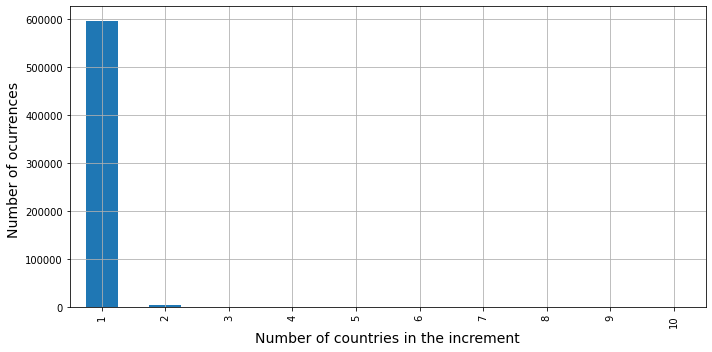

In [108]:
ax=country_increment_df.plot(kind='bar', grid=True, legend=False, figsize=(10,5));
ax.set_xlabel('Number of countries in the increment', fontsize=14)
ax.set_ylabel('Number of ocurrences ', fontsize=14);
plt.tight_layout()
plt.savefig(os.path.join('figs', f'song_increments_per_country_05_{source}.png'))

### Study the songs by their origin country

In [109]:
country_propagation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
Belarus,0,2060,654,225,134,82,53,44,25,19,...,0,0,0,0,0,0,0,0,0,0
Finland,0,2053,853,450,256,164,113,92,61,43,...,0,0,0,0,0,0,0,0,0,0
Ukraine,0,3468,1127,524,281,176,107,65,43,27,...,0,0,0,0,0,0,0,0,0,0
USA,0,13086,4855,2323,1396,850,575,381,330,216,...,0,0,0,0,0,0,0,0,0,0
Sweden,0,3093,1284,746,459,319,225,157,116,83,...,0,0,0,0,0,0,0,0,0,0


In [110]:
country_propagation_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,67.0,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0
mean,0.0,1303.761194,489.208955,248.701493,143.895522,91.746269,61.253731,42.835821,32.164179,23.014925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,2652.446727,973.432112,489.161311,286.787913,179.100221,120.155120,83.715173,65.185190,45.108453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,91.000000,39.000000,15.500000,8.500000,4.000000,2.500000,2.000000,1.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,324.000000,131.000000,71.000000,35.000000,23.000000,16.000000,12.000000,7.000000,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,1151.000000,475.000000,230.500000,133.500000,86.500000,59.000000,40.000000,30.000000,22.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,13086.000000,4855.000000,2323.000000,1396.000000,850.000000,575.000000,381.000000,330.000000,216.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


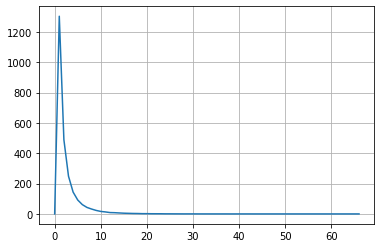

In [111]:
country_propagation_df.describe().loc['mean'].plot(grid=True)
plt.show()

In [112]:
country_propagation_agg_df = pd.DataFrame(0,index=country_propagation_df.index, columns=['1','2-5', '6-10', '11-20', '+20'])

In [113]:
country_propagation_agg_df

,1,2-5,6-10,11-20,+20
Belarus,0,0,0,0,0
Finland,0,0,0,0,0
Ukraine,0,0,0,0,0
USA,0,0,0,0,0
Sweden,0,0,0,0,0
Romania,0,0,0,0,0
Turkey,0,0,0,0,0
Bulgaria,0,0,0,0,0
Belgium,0,0,0,0,0
Germany,0,0,0,0,0


In [116]:
country_propagation_agg_df['1']=country_propagation_df['0']
country_propagation_agg_df['2-5']=country_propagation_df[['1','2','3','4']].sum(axis=1)
country_propagation_agg_df['6-10']=country_propagation_df[['5','6','7','8','9']].sum(axis=1)
country_propagation_agg_df['11-20']=country_propagation_df[[str(i) for i in np.arange(11,21)]].sum(axis=1)
country_propagation_agg_df['+20']=country_propagation_df[[str(i) for i in np.arange(21,67)]].sum(axis=1)

In [117]:
country_propagation_agg_df= country_propagation_agg_df.sort_index()

In [118]:
country_propagation_agg_df

,1,2-5,6-10,11-20,+20
Argentina,0,586,59,18,4
Australia,0,2588,244,53,3
Austria,0,738,69,13,0
Belarus,0,3073,223,39,5
Belgium,0,853,84,28,4
Bolivia,0,24,6,0,0
Brazil,0,12841,1562,329,41
Bulgaria,0,1740,251,50,6
Canada,0,4483,542,110,10
Chile,0,1092,134,14,1


In [119]:
country_propagation_norm_agg_df= country_propagation_agg_df.div(country_propagation_agg_df.sum(axis=1), axis=0)

In [120]:
country_propagation_norm_agg_df

,1,2-5,6-10,11-20,+20
Argentina,0.0,0.878561,0.088456,0.026987,0.005997
Australia,0.0,0.896122,0.084488,0.018352,0.001039
Austria,0.0,0.900000,0.084146,0.015854,0.000000
Belarus,0.0,0.920060,0.066766,0.011677,0.001497
Belgium,0.0,0.880289,0.086687,0.028896,0.004128
Bolivia,0.0,0.800000,0.200000,0.000000,0.000000
Brazil,0.0,0.869221,0.105733,0.022270,0.002775
Bulgaria,0.0,0.850024,0.122618,0.024426,0.002931
Canada,0.0,0.871331,0.105345,0.021380,0.001944
Chile,0.0,0.879936,0.107977,0.011281,0.000806


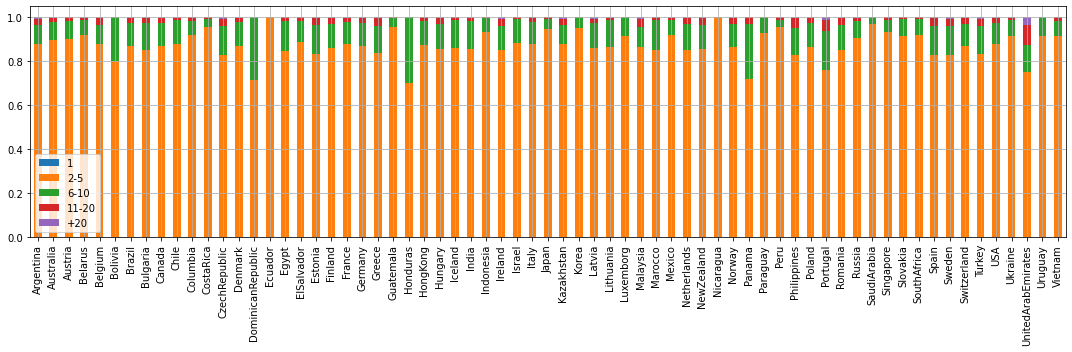

In [121]:
country_propagation_norm_agg_df.plot.bar(stacked=True, figsize=(15,5), grid=True);
plt.tight_layout()
plt.savefig(os.path.join('figs',f'songs_per_country_{source}_05.png'))

### Analysis of the link weights

In [122]:
mean_edges_df.head()

,origin,destination,weight
0,Russia,Belarus,0.162616
1,Ukraine,Poland,0.351750
2,Brazil,USA,0.213352
3,Brazil,Russia,0.274881
4,France,USA,0.950175


In [123]:
mean_edges_df['weight'].describe()

count    499.000000
mean       0.523371
std        0.372595
min        0.010510
25%        0.230591
50%        0.421248
75%        0.766019
max        1.849538
Name: weight, dtype: float64

In [124]:
sum_edges_df.head()

,origin,destination,weight
0,Russia,Belarus,4.553259
1,Ukraine,Poland,6.683252
2,Brazil,USA,40.536802
3,Brazil,Russia,28.312763
4,France,USA,16.152979


In [125]:
sum_edges_df['weight'].describe()

count    499.000000
mean       4.851215
std        5.538920
min        0.042040
25%        1.703562
50%        3.253063
75%        5.531011
max       40.556560
Name: weight, dtype: float64

In [126]:
def keep_nlargest(df, n):
    largest=df.groupby('origin')['weight'].nlargest(n).to_frame()
    l=largest.index.tolist()
    index_to_keep= [j[1] for j in l]
    return df.loc[index_to_keep]

In [127]:
top_to_keep= 2
mean_edges_largest_df=keep_nlargest(mean_edges_df, top_to_keep)
mean_edges_largest_df.head(10)

,origin,destination,weight
480,Argentina,Germany,1.287190
213,Argentina,Australia,1.146820
126,Australia,Mexico,0.647096
156,Australia,Brazil,0.598620
91,Belarus,Portugal,1.022187
344,Belarus,Russia,0.585524
437,Brazil,Columbia,0.546596
331,Brazil,Lithuania,0.369793
441,Bulgaria,Russia,1.161286
203,Bulgaria,Poland,0.702733


In [128]:
sum_edges_largest_df=keep_nlargest(sum_edges_df,top_to_keep)
sum_edges_largest_df.head(10)

,origin,destination,weight
214,Argentina,Poland,7.293331
480,Argentina,Germany,5.148758
125,Australia,USA,14.086080
136,Australia,Germany,5.907974
91,Belarus,Portugal,12.266246
344,Belarus,Russia,11.710471
2,Brazil,USA,40.536802
3,Brazil,Russia,28.312763
203,Bulgaria,Poland,8.432799
441,Bulgaria,Russia,5.806431


### Generate graph

In [129]:
def plot_graph(G):
    pos = nx.kamada_kawai_layout(G);
    plt.figure(3,figsize=(12,12)) 
    nx.draw_networkx_nodes(G, pos);
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.3);
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='red')

    plt.axis("off")

    plt.show()

def convert_dataframe_for_chor_fn(df):
    countries = df['origin'].unique()
    out_df = pd.DataFrame(0, index=countries, columns=countries)
    
    for i, r in df.iterrows():
        out_df.loc[r['origin'],r['destination']] = r['weight']
    
    out_df=out_df.fillna(0)
    return out_df

from importlib import reload
import matplotlib_chord
reload(matplotlib_chord)
from matplotlib_chord import chordDiagram, hex2rgb

def generate_chord_plot(df,fig_name):
    X= df.to_numpy()
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,3])
    
    #ax = plt.axes([0,0,2,3])
    #ax = plt.axes([0,0,1,1])

    nodePos = chordDiagram(X, ax, colors=sns.color_palette("bright", df.shape[0]))
    ax.axis('off')
    prop = dict(fontsize=5*2, ha='center', va='center')
    
    nodes = df.index
    for i in range(len(nodes)):
        if nodePos[i][2]<= 0:
            ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][2]+90, **prop)
        else:
            ax.text(nodePos[i][0], nodePos[i][1], nodes[i], rotation=nodePos[i][2]-90, **prop)
    
    ax.plot()
    plt.savefig(os.path.join('figs',f'05_chord_{fig_name}.png'), bbox_inches='tight')

def calculate_graph_metrics(G):
    b_centrality =nx.betweenness_centrality(G)
    d_centrality =nx.degree_centrality(G)
    c_centrality =nx.closeness_centrality(G)
    out_centrality = nx.out_degree_centrality(G)
    in_centrality = nx.in_degree_centrality(G)

    centrality_df = pd.DataFrame.from_records([b_centrality]).T
    centrality_df.columns=['betweenness']

    centrality_df['degree'] = pd.DataFrame.from_records([d_centrality]).T
    centrality_df['closeness'] = pd.DataFrame.from_records([c_centrality]).T
    centrality_df['in_degree'] = pd.DataFrame.from_records([in_centrality]).T
    centrality_df['out_degree'] = pd.DataFrame.from_records([out_centrality]).T

    centrality_df['diff_degree']= centrality_df['out_degree'] - centrality_df['in_degree']
    
    return centrality_df

def complete_graph_nodes(G):
    graph_nodes= set(G.nodes)
    all_nodes = set(countries)
    nodes_to_add = all_nodes - graph_nodes
    for n in nodes_to_add:
        G.add_node(n)
    return G

### Global graph

In [130]:
min_mean_weight= mean_edges_df['weight'].quantile(0.9)
min_sum_weight= sum_edges_df['weight'].quantile(0.9)

mean_G = nx.from_pandas_edgelist(mean_edges_df[mean_edges_df['weight']>=min_mean_weight], 
                                 'origin', 'destination', ['weight'], create_using=nx.DiGraph())
mean_G = complete_graph_nodes(mean_G)

sum_G= nx.from_pandas_edgelist(sum_edges_df[sum_edges_df['weight']>=min_sum_weight], 
                               'origin', 'destination', ['weight'], create_using=nx.DiGraph())
sum_G = complete_graph_nodes(sum_G)

#### Density of the graph

In [131]:
mean_full_G = nx.from_pandas_edgelist(mean_edges_df, 
                                 'origin', 'destination', ['weight'], create_using=nx.DiGraph())
nx.density(mean_full_G),nx.density(mean_G),

(0.17435359888190077, 0.011307100859339666)

In [132]:
mean_full_G.number_of_edges()

499

In [133]:
chord_df = convert_dataframe_for_chor_fn(sum_edges_largest_df)

In [134]:
chord_df.head()

,Argentina,Australia,Belarus,Brazil,Bulgaria,Canada,Chile,CzechRepublic,Denmark,Egypt,...,Singapore,Slovakia,Spain,Sweden,Switzerland,Turkey,USA,Ukraine,UnitedArabEmirates,Vietnam
Argentina,0,0,0,0.0,0,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0.000000,0.0,0,0
Australia,0,0,0,0.0,0,0,0.0,0.0,0,0,...,0,0,0,0,0,0,14.086080,0.0,0,0
Belarus,0,0,0,0.0,0,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0.000000,0.0,0,0
Brazil,0,0,0,0.0,0,0,0.0,0.0,0,0,...,0,0,0,0,0,0,40.536802,0.0,0,0
Bulgaria,0,0,0,0.0,0,0,0.0,0.0,0,0,...,0,0,0,0,0,0,0.000000,0.0,0,0


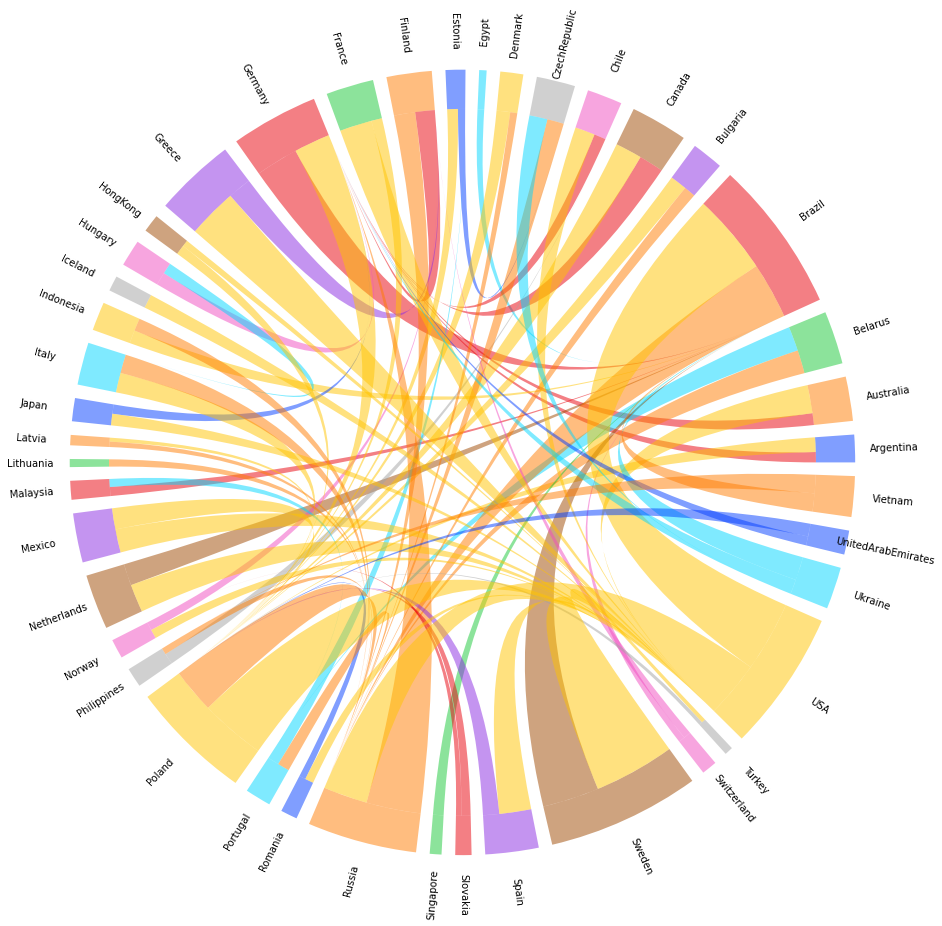

In [135]:
generate_chord_plot(chord_df,f'sum_{source}')

In [136]:
mean_edges_largest_df

,origin,destination,weight
480,Argentina,Germany,1.287190
213,Argentina,Australia,1.146820
126,Australia,Mexico,0.647096
156,Australia,Brazil,0.598620
91,Belarus,Portugal,1.022187
344,Belarus,Russia,0.585524
437,Brazil,Columbia,0.546596
331,Brazil,Lithuania,0.369793
441,Bulgaria,Russia,1.161286
203,Bulgaria,Poland,0.702733


In [137]:
mean_chord_df = convert_dataframe_for_chor_fn(mean_edges_largest_df)
mean_chord_df

,Argentina,Australia,Belarus,Brazil,Bulgaria,Canada,Chile,CzechRepublic,Denmark,Egypt,...,Sweden,Switzerland,Turkey,USA,Ukraine,UnitedArabEmirates,Vietnam,Columbia,Ireland,Austria
Argentina,0,1.14682,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Australia,0,0.00000,0,0.598620,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Belarus,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Brazil,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.546596,0.000000,0.000000
Bulgaria,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Canada,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Chile,0,0.00000,0,0.000000,0.00000,1.203377,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.666787,0.000000,0,0.000000,0.000000,0.000000,0.000000
CzechRepublic,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.159890,1.134494,0,0.000000,0.000000,0.000000,0.000000
Denmark,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Egypt,0,0.00000,0,1.110561,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000


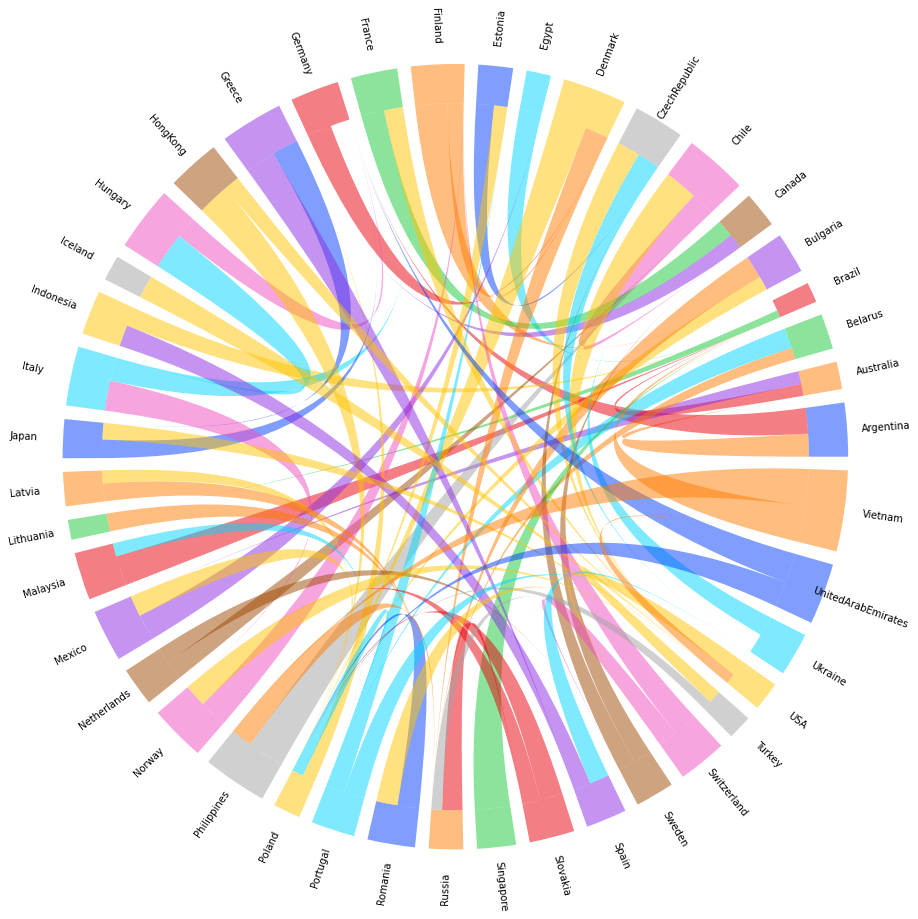

In [138]:
generate_chord_plot(mean_chord_df, f'mean_{source}')

In [139]:
mean_chord_df

,Argentina,Australia,Belarus,Brazil,Bulgaria,Canada,Chile,CzechRepublic,Denmark,Egypt,...,Sweden,Switzerland,Turkey,USA,Ukraine,UnitedArabEmirates,Vietnam,Columbia,Ireland,Austria
Argentina,0,1.14682,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Australia,0,0.00000,0,0.598620,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Belarus,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Brazil,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.546596,0.000000,0.000000
Bulgaria,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Canada,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Chile,0,0.00000,0,0.000000,0.00000,1.203377,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.666787,0.000000,0,0.000000,0.000000,0.000000,0.000000
CzechRepublic,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.159890,1.134494,0,0.000000,0.000000,0.000000,0.000000
Denmark,0,0.00000,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000
Egypt,0,0.00000,0,1.110561,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000


In [140]:
mean_chord_df.loc['Turkey']

Argentina             0.000000
Australia             0.000000
Belarus               0.000000
Brazil                0.000000
Bulgaria              0.000000
Canada                0.000000
Chile                 0.000000
CzechRepublic         0.000000
Denmark               0.000000
Egypt                 0.000000
Estonia               0.000000
Finland               0.000000
France                0.000000
Germany               0.000000
Greece                0.000000
HongKong              0.000000
Hungary               0.000000
Iceland               0.000000
Indonesia             0.000000
Italy                 0.000000
Japan                 0.000000
Latvia                0.000000
Lithuania             0.000000
Malaysia              0.000000
Mexico                0.000000
Netherlands           0.000000
Norway                0.000000
Philippines           0.000000
Poland                0.455633
Portugal              0.000000
Romania               0.000000
Russia                0.000000
Singapor

In [141]:
sum_G_metrics= calculate_graph_metrics(sum_G)
mean_G_metrics= calculate_graph_metrics(mean_G)

In [142]:
mean_G_metrics.sort_values('betweenness', ascending=False)

,betweenness,degree,closeness,in_degree,out_degree,diff_degree
Italy,0.006177,0.121212,0.045455,0.045455,0.075758,0.030303
Germany,0.003846,0.090909,0.087662,0.075758,0.015152,-0.060606
Chile,0.002564,0.075758,0.020202,0.015152,0.060606,0.045455
Norway,0.002214,0.075758,0.034632,0.015152,0.060606,0.045455
Denmark,0.002214,0.045455,0.063131,0.015152,0.030303,0.015152
Finland,0.001865,0.075758,0.068182,0.060606,0.015152,-0.045455
Philippines,0.001632,0.045455,0.015152,0.015152,0.030303,0.015152
France,0.000932,0.030303,0.034632,0.015152,0.015152,0.000000
Bulgaria,0.000699,0.030303,0.049495,0.015152,0.015152,0.000000
Egypt,0.000233,0.030303,0.015152,0.015152,0.015152,0.000000


In [143]:
mean_G_metrics.sort_values('in_degree', ascending=False)

,betweenness,degree,closeness,in_degree,out_degree,diff_degree
USA,0.000000,0.106061,0.107843,0.106061,0.000000,-0.106061
Poland,0.000000,0.106061,0.106534,0.106061,0.000000,-0.106061
Germany,0.003846,0.090909,0.087662,0.075758,0.015152,-0.060606
Russia,0.000000,0.060606,0.109971,0.060606,0.000000,-0.060606
Brazil,0.000000,0.060606,0.063131,0.060606,0.000000,-0.060606
Finland,0.001865,0.075758,0.068182,0.060606,0.015152,-0.045455
Italy,0.006177,0.121212,0.045455,0.045455,0.075758,0.030303
Canada,0.000000,0.030303,0.053872,0.030303,0.000000,-0.030303
Spain,0.000000,0.030303,0.030303,0.030303,0.000000,-0.030303
Ukraine,0.000000,0.015152,0.015152,0.015152,0.000000,-0.015152


In [144]:
mean_G_metrics.sort_values('out_degree', ascending=False)

,betweenness,degree,closeness,in_degree,out_degree,diff_degree
Greece,0.000000,0.075758,0.000000,0.000000,0.075758,0.075758
Italy,0.006177,0.121212,0.045455,0.045455,0.075758,0.030303
Chile,0.002564,0.075758,0.020202,0.015152,0.060606,0.045455
Norway,0.002214,0.075758,0.034632,0.015152,0.060606,0.045455
Vietnam,0.000000,0.045455,0.000000,0.000000,0.045455,0.045455
Mexico,0.000000,0.045455,0.000000,0.000000,0.045455,0.045455
Romania,0.000000,0.030303,0.000000,0.000000,0.030303,0.030303
Argentina,0.000000,0.030303,0.000000,0.000000,0.030303,0.030303
CzechRepublic,0.000000,0.030303,0.000000,0.000000,0.030303,0.030303
Denmark,0.002214,0.045455,0.063131,0.015152,0.030303,0.015152


### UN migrant stock comparison

In [145]:
meanigful_countries= ["Argentina" ,"Australia", "Austria","Belarus", 
                      "Belgium" ,"Brazil" , "Bulgaria","Canada", 
                      "Denmark" , "Estonia", "Finland" ,"France"  , 
                      "Germany" ,"Greece"  , "Hungary" ,"Iceland", 
                      "Indonesia" ,"Ireland" , "Italy","Kazakhstan", 
                      "Latvia","Lithuania", "Luxembourg","Malaysia", 
                      "Morocco" ,"Netherlands","New Zealand" ,"Norway" , 
                      "Paraguay"  ,"Philippines" , "Poland" ,"Portugal" ,
                      "Romania","Saudi Arabia", "Singapore","Slovakia",
                      "South Africa" ,"Sweden"  , "Switzerland" , "United Arab Emirates"  , 
                      "United Kingdom" ,"United States of America","Uruguay" ]

non_meaningful_countries=spotify_countries= ['Ecuador', 'Panama',
                                             'Spain', 'Peru','Uruguay',
                                             'Costa Rica',  'Mexico',  'Norway','Taiwan', 
                                             'El Salvador', 'Chile', 'Japan', 'Honduras', 'Guatemala',
                                             'Bolivia',  'CzechRepublic','Dominican Republic', 
                                            'Hong Kong', 'Russia',
                                            'India','Ukraine', 'Egypt', 'Nigeria', 'South Korea',
                                           'Nicaragua',  'Israel','Vietnam']

In [146]:
len(meanigful_countries),len(non_meaningful_countries)

(43, 27)

In [147]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [148]:
world[world['name'].str.startswith('Si')]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
64,6163195,Africa,Sierra Leone,SLE,10640.0,"POLYGON ((-13.24655 8.90305, -12.71196 9.34271..."


In [149]:
mean_countries_gdf=world[world['name'].isin(meanigful_countries)]

In [150]:
mean_countries_gdf.shape

(42, 6)

In [151]:
no_mean_countries_gdf=world[world['name'].isin(non_meaningful_countries)]

In [152]:
no_mean_countries_gdf.shape

(24, 6)

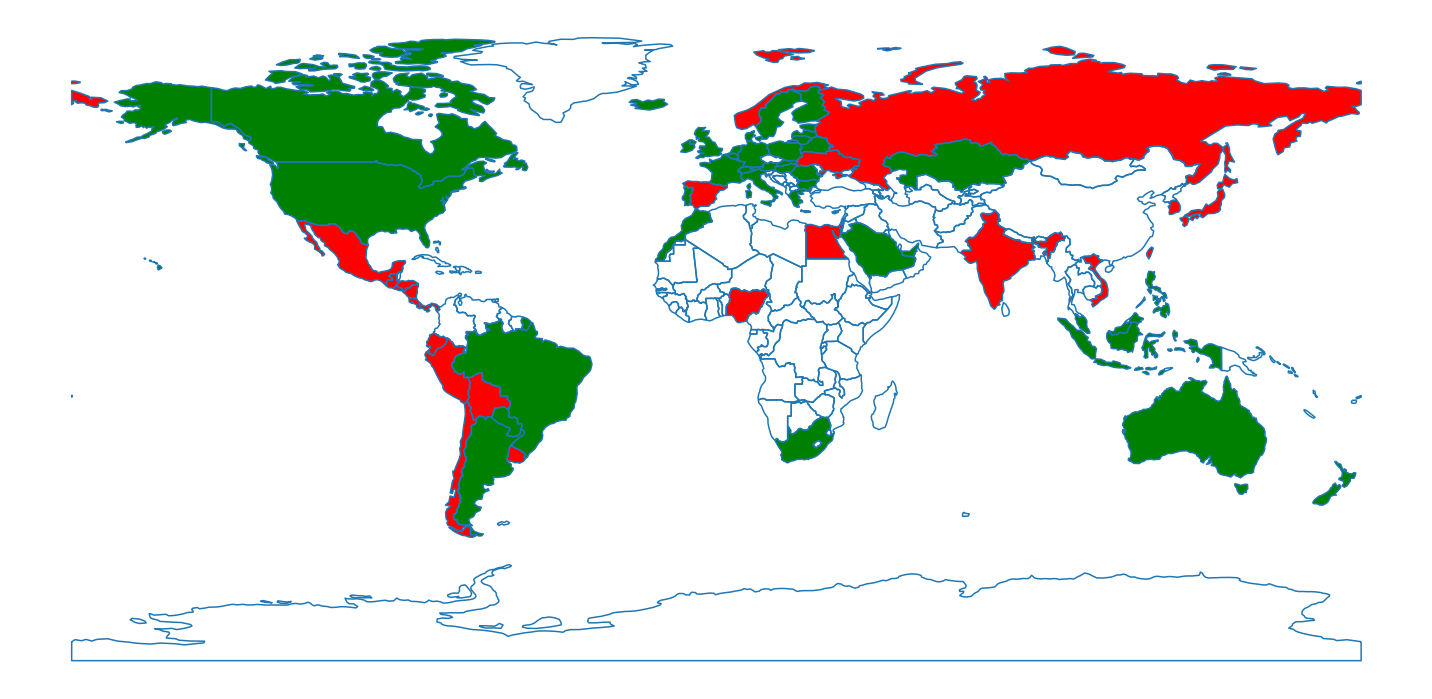

In [153]:
ax= mean_countries_gdf.plot(color='green', figsize=(20,15))
no_mean_countries_gdf.plot(ax=ax,color='red')

world.boundary.plot(ax=ax);
ax.set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join('figs',f'05_map_corr_human_flows_{source}.png'),bbox_inches='tight')

In [154]:
print("That's all folks!")

That's all folks!
